# Predicting Diabetes Onset
### By: Bethany Thompson
### Date: December 2020
## Goals
- Create a machine learning algorithm to predict if a patient has diabetes or not  

## Conclusions
#### Final Model Selected:
#### Model Metrics:
## Next Steps
## How to Reproduce:

# Table of Contents <a class="anchor" id="top"></a>
1. [Acquire](#acquire)
2. [Prepare](#prepare)
3. [Explore](#explore)
4. [Modeling](#model)
5. [Final Conclusions](#fin)

In [28]:
# initial imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Acquire <a class="anchor" id="acquire"></a>
Dataset from UCI Machine Learning via Kaggle [here](https://www.kaggle.com/uciml/pima-indians-diabetes-database) saved in .csv file  
#### Steps:
- read csv file into df
- summarize data
- create data dictionary

In [2]:
df = pd.read_csv('diabetes.csv')

In [3]:
df.shape

(768, 9)

In [4]:
df.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [6]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


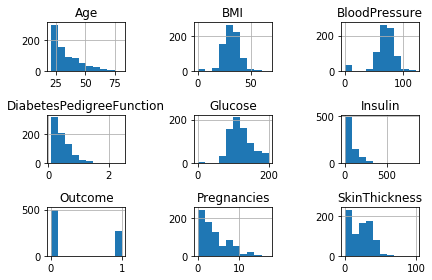

In [7]:
df.hist()
plt.tight_layout()

In [8]:
#for column in df.columns:
#    print(column)
#    print(df[column].value_counts())
#    print('')

In [9]:
# checking observations with 0 for BMI
df[df.BMI == 0]

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
9,8,125,96,0,0,0.0,0.232,54,1
49,7,105,0,0,0,0.0,0.305,24,0
60,2,84,0,0,0,0.0,0.304,21,0
81,2,74,0,0,0,0.0,0.102,22,0
145,0,102,75,23,0,0.0,0.572,21,0
371,0,118,64,23,89,0.0,1.731,21,0
426,0,94,0,0,0,0.0,0.256,25,0
494,3,80,0,0,0,0.0,0.174,22,0
522,6,114,0,0,0,0.0,0.189,26,0
684,5,136,82,0,0,0.0,0.640,69,0


In [10]:
# checking observations with 0 for glucose
df[df.Glucose == 0]

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
75,1,0,48,20,0,24.7,0.140,22,0
182,1,0,74,20,23,27.7,0.299,21,0
342,1,0,68,35,0,32.0,0.389,22,0
349,5,0,80,32,0,41.0,0.346,37,1
502,6,0,68,41,0,39.0,0.727,41,1


### Takeaways
768 observations  
- 8 columns and 1 predictive column as diabetic or not  

All numeric values, integers or floats  
- average diabetic diagnosis is 0, non-diabetic  
- all continuous features except pregnancies and outcome which are discrete  

No null values  
- observations with 0 for values that cannot be, such as BMI and Blood Pressure, have 0 for multiple features  
    - could be null values that were replaced with 0

[Table of Contents](#top)

# Prepare <a class="anchor" id="prepare"></a>
For Exploration:
- create new features by bining demographics 
    - age into 20s, 30s, etc
    - bmi into low, middle, high
    - blood pressure into low, good, high

For Modeling:
- scale the data
- determine if outliers/anomalies to remove
- split into train, valideate, test
- create features based on clustering

In [11]:
# removing observations with a 0 for both BMI and BloodPressure
df = df[~((df.BloodPressure == 0) & (df.BMI == 0))]

### Feature Engineering
- binning features

In [12]:
# 1 = 'early_20s', 2 = 'late_20s', 3 = '30s', 4 = '40s_to_80s']
# (20.999, 24.0] < (24.0, 29.0] < (29.0, 41.0] < (41.0, 81.0]
df['age_bins'] = pd.qcut(df.Age, 4, labels=[1,2,3,4])

In [13]:
# 1 = low, 2 = medium, 3 = high
# (-0.001, 29.0] < (29.0, 34.867] < (34.867, 67.1]
df['bmi_bins'] = pd.qcut(df.BMI, 3, labels=[1,2,3])

In [14]:
# 1 = low, 2 = medium, 3 = high
# (-0.001, 66.0] < (66.0, 76.0] < (76.0, 122.0]
df['bp_bins'] = pd.qcut(df.BloodPressure, 3, labels=[1,2,3])

### Splitting Data
- 70% train
- 20% validate
- 10% test

In [20]:
# Import to use split function, can only split two at a time
from sklearn.model_selection import train_test_split

# First, split into train + validate together and test by itself
# Test will be %10 of the data, train + validate is %70 for now
# Set random_state so we can reproduce the same 'random' data
train_validate, test = train_test_split(df, test_size = .10, random_state = 123)

# Second, we split train + validate into their seperate variables
# Train will be %70 of the data, Validate will be %20 of the data
train, validate = train_test_split(train_validate, test_size = .22, random_state = 123)

# These two print functions allow us to ensure the date is properly split
# Will print the shape of each variable when running the function
print("train shape: ", train.shape, ", validate shape: ", validate.shape, ", test shape: ", test.shape)

# Will print the shape of eachvariable as a percentage of the total data set
# Varialbe to hold the sum of all rows (total observations in the data)
total = df.count()[0]
print("\ntrain percent: ", round(((train.shape[0])/total),2) * 100, 
        ", validate percent: ", round(((validate.shape[0])/total),2) * 100, 
        ", test percent: ", round(((test.shape[0])/total),2) * 100)

train shape:  (533, 12) , validate shape:  (151, 12) , test shape:  (77, 12)

train percent:  70.0 , validate percent:  20.0 , test percent:  10.0


In [22]:
train.head(5)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,age_bins,bmi_bins,bp_bins
400,4,95,64,0,0,32.0,0.161,31,1,3,2,1
610,3,106,54,21,158,30.9,0.292,24,0,1,2,1
116,5,124,74,0,0,34.0,0.220,38,1,3,2,2
231,6,134,80,37,370,46.2,0.238,46,1,4,3,3
261,3,141,0,0,0,30.0,0.761,27,1,2,2,1


### Scaling the Data

### Creating Clusters on Scaled Data

### Takeaways
- removed observations that had 0 for BMI and BP, these observations had other 0 values as well and were note useful for exploration and modeling
- added new features based on binning continuous features

### Next Steps
- deal with observations that are 0 which cannot be 0, such as glucose and BMI
- create clusters
- scale the data for modeling
- put work into a prepare.py module and clean up the code in the notebook

[Table of Contents](#top)

# Explore <a class="anchor" id="explore"></a>
- determine trends in patient being diabetic or not
- test the significance with hypothesis testing

Text(0, 0.5, 'Count of Patients')

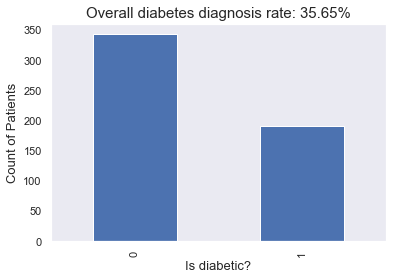

In [53]:
train.Outcome.value_counts().sort_index().plot.bar()
diabetic_rate = train.Outcome.mean()
plt.title(f"Overall diabetes diagnosis rate: {diabetic_rate:.2%}", size=15)
plt.xlabel('Is diabetic?', size=13)
plt.ylabel('Count of Patients', size=13)

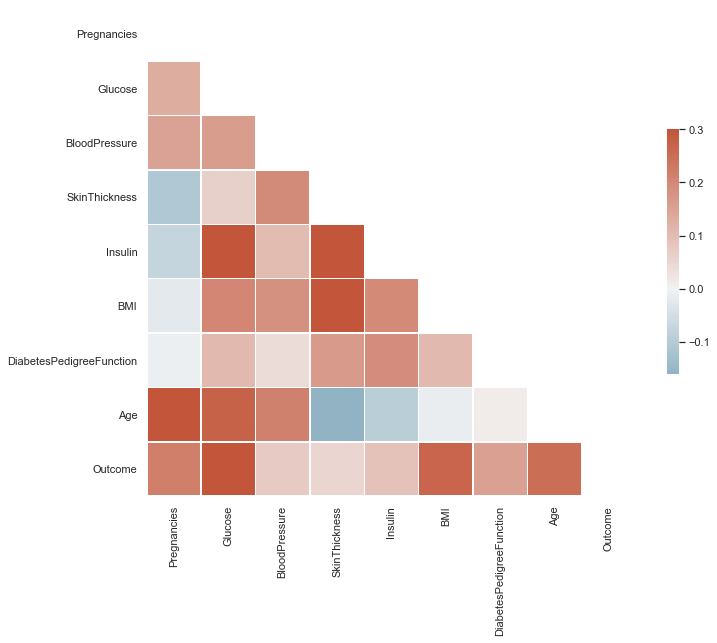

In [29]:
corr = train.corr()

sns.set_theme(style="white")

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

### Looking at Independent Features vs. Diabetic Outcome

/usr/local/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


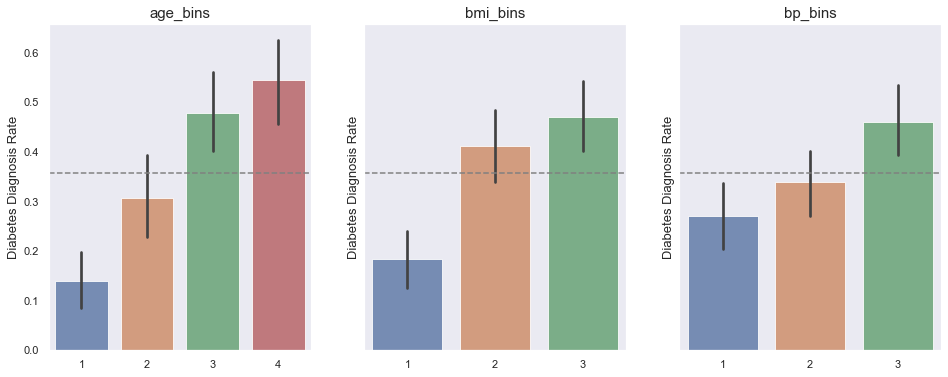

In [69]:
# categorical features we can compare
features = ['age_bins', 'bmi_bins', 'bp_bins']

# overall diagnosis of diabetes on whole train df
diabetic_rate = train.Outcome.mean()

# plotting subgroups diagnosis rate and comparing to overal with dashed line
_, ax = plt.subplots(nrows=1, ncols=3, figsize=(16, 6), sharey=True)
for i, feature in enumerate(features):
    sns.barplot(feature, 'Outcome', data=train, ax=ax[i], alpha=.8)
    ax[i].set_xlabel('')
    ax[i].set_ylabel('Diabetes Diagnosis Rate', size=13)
    ax[i].set_title(feature, size=15)
    ax[i].axhline(diabetic_rate, ls='--', color='grey')

Text(0.5, 1.0, 'Diabetes Diagnosis by Age and BMI')

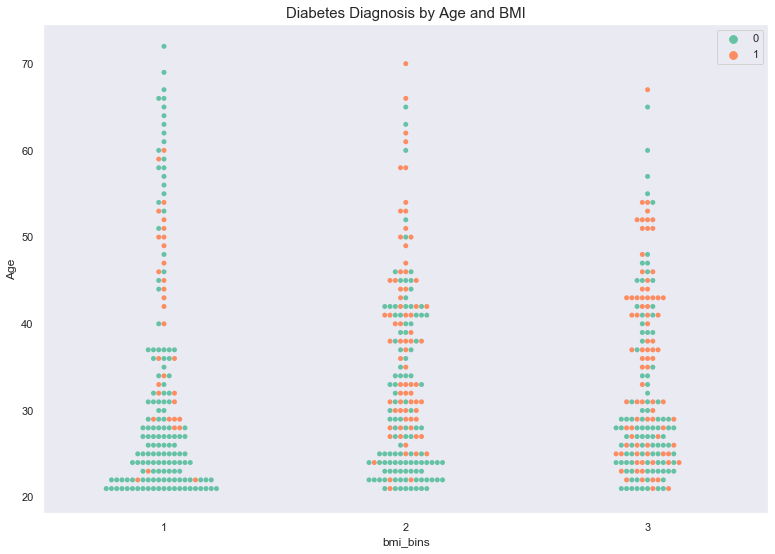

In [66]:
plt.figure(figsize=(13,9))
sns.swarmplot(x="bmi_bins", y="Age", data=train, hue="Outcome", palette="Set2")
plt.legend()
plt.title('Diabetes Diagnosis by Age and BMI', size=15)

Text(0.5, 1, 'Diabetes Diagnosis with BMI vs. Glucose')

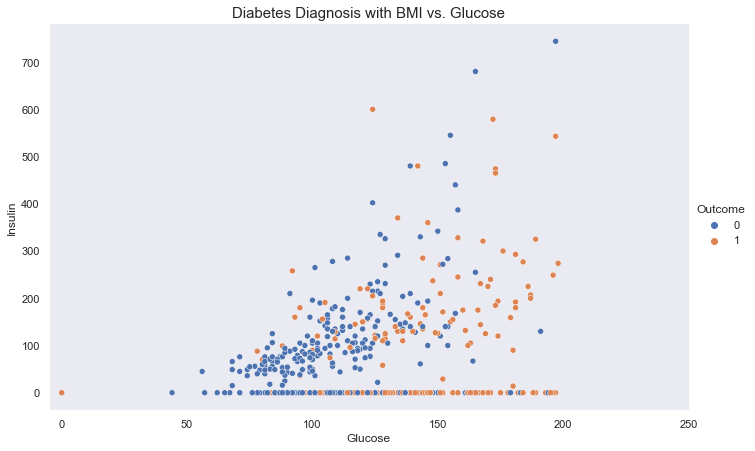

In [87]:
sns.relplot(x="Glucose", y="Insulin", hue="Outcome", data=train, height=6, aspect=1.6)
plt.xlim(-5, 250)
plt.title('Diabetes Diagnosis with BMI vs. Glucose', size=15)

### Takeaways


### Next Steps
- create clusters for new features based on BMI, age, etc.
- bin more continuous variables

[Table of Contents](#top)

# Modeling <a class="anchor" id="model"></a>
##### Outcome of patient being diabetic or not is the predictive feature, Y
#### Steps
1. Create the Baseline model for comparison based on most common diagnosis
2. Create models fit to the train df only
3. Validate on top 3 models, tuning hyperparameters
4. Use final top model evaluated on test
5. Determine next steps/conclusions

### Baseline

In [70]:
train.Outcome.value_counts()

0    343
1    190
Name: Outcome, dtype: int64

Text(0, 0.5, 'Count of Patients')

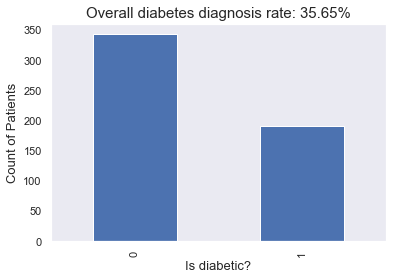

In [90]:
# taking a look at the same barplot again, overall rate of diabetes diagnosis
train.Outcome.value_counts().sort_index().plot.bar()
diabetic_rate = train.Outcome.mean()
plt.title(f"Overall diabetes diagnosis rate: {diabetic_rate:.2%}", size=15)
plt.xlabel('Is diabetic?', size=13)
plt.ylabel('Count of Patients', size=13)

In [88]:
# most common diagnosis is non-diabetic, this will be our baseline
train['baseline_prediction'] = 0

baseline_accuracy = (train.baseline_prediction == train.Outcome).mean()

print(f'baseline accuracy: {baseline_accuracy:.2%}')

baseline accuracy: 64.35%


/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


## Creating Classification Models
#### Models to Create
- LogisticRegression
- DecisionTree
- RandomForest
- KNN

[Table of Contents](#top)

# Conclusions <a class="anchor" id="fin"></a>

[Table of Contents](#top)